# 1. Library prep

In [421]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import eda
from model import make_confusion_matrix
import stanza_nlp as stnlp

# NLP stuff
# TODO: remove unnecessary imports
from nltk import ngrams, pos_tag
from nltk.corpus import names, stopwords, wordnet as wn
from nltk.tokenize import word_tokenize, sent_tokenize, WordPunctTokenizer, RegexpTokenizer, MWETokenizer
from nltk.cluster import cosine_distance, euclidean_distance
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.chunk import ne_chunk

# other string processing
import re
import string

# classifiers
from sklearn.ensemble import RandomForestClassifier, BaseEnsemble
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, CategoricalNB

# clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration

# model selection and metric helpers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.metrics import classification_report, roc_curve, fbeta_score, log_loss 
from sklearn.metrics import roc_auc_score, euclidean_distances, make_scorer, confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from joblib import dump, load
import os

RANDOM = 42

Run this if NLTK hasn't been set up locally

In [2]:
#import nltk
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# 2. Data loading and initial inspection

From the README:

- Column 1: the ID of the statement ([ID].json).
- Column 2: the label.
- Column 3: the statement.
- Column 4: the subject(s).
- Column 5: the speaker.
- Column 6: the speaker's job title.
- Column 7: the state info.
- Column 8: the party affiliation.
- Column 9-13: the total credit history count, including the current statement.
  - 9: barely true counts.
  - 10: false counts.
  - 11: half true counts.
  - 12: mostly true counts.
  - 13: pants on fire counts.
- Column 14: the context (venue / location of the speech or statement).

In [51]:
# read the LIAR dataset

liar_credit_hist_headers = ['speaker_bt', 'speaker_f', 'speaker_ht', 'speaker_mt', 'speaker_pof']
liar_speaker_headers = ['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation'] + liar_credit_hist_headers
liar_column_headers = ['id', 'label', 'statement', 'subjects']  + liar_speaker_headers + ['context']

# read the pre-prepared training, validation and test sets

liar_train = pd.read_csv("./data/liar_dataset/train.tsv", sep='\t', names=liar_column_headers)
liar_valid = pd.read_csv("./data/liar_dataset/valid.tsv", sep='\t', names=liar_column_headers)
liar_test = pd.read_csv("./data/liar_dataset/test.tsv", sep='\t', names=liar_column_headers)

# combine the pre-prepared training and validation sets; we want to do our own 5-fold cv

liar_train = liar_train.append(liar_valid)
liar_train.set_index('id', inplace=True)

liar_train

,label,statement,subjects,speaker,speaker_job,speaker_us_state,speaker_affiliation,speaker_bt,speaker_f,speaker_ht,speaker_mt,speaker_pof,context
id,,,,,,,,,,,,,
2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419.json,half-true,"For the first time in more than a decade, impo...","energy,oil-spill,trade",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a press conference
12548.json,mostly-true,Says Donald Trump has bankrupted his companies...,candidates-biography,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,a speech on the economy
401.json,true,"John McCain and George Bush have ""absolutely n...",health-care,campaign-defend-america,NaN,"Washington, D.C.",none,0.0,1.0,0.0,2.0,0.0,a television ad


In [52]:
liar_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11524 entries, 2635.json to 9117.json
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   label                11524 non-null  object 
 1   statement            11524 non-null  object 
 2   subjects             11522 non-null  object 
 3   speaker              11522 non-null  object 
 4   speaker_job          8282 non-null   object 
 5   speaker_us_state     9037 non-null   object 
 6   speaker_affiliation  11522 non-null  object 
 7   speaker_bt           11522 non-null  float64
 8   speaker_f            11522 non-null  float64
 9   speaker_ht           11522 non-null  float64
 10  speaker_mt           11522 non-null  float64
 11  speaker_pof          11522 non-null  float64
 12  context              11410 non-null  object 
dtypes: float64(5), object(8)
memory usage: 1.2+ MB


In [53]:
liar_train.iloc[0]['statement']

'Says the Annies List political group supports third-trimester abortions on demand.'

Plot the truth values of the dataset

In [155]:
liar_label_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']

def liar_truthdist_subj(subj=None, ax=None, saveplot=True, longtitle=True):
    """
    Plots the truth distribution of the LIAR dataset, optionally by subject
    Return the dataframe representing the plot
    """   
    if not ax:
        fig, ax = plt.subplots()

    if subj == None:
        subj_filter = liar_train['subjects'].apply(lambda x: True)
        plt_title = 'distribution of truth values'
        filename = './image/liar_truthvals_dist.png'
    else:
        subj_filter = liar_train['subject_list'].apply(lambda entry: subj in entry)
        if longtitle:
            plt_title = '"' + subj + '": distribution of truth values'
        else:
            plt_title = subj
        filename = './image/liar_truthvals_dist_' + subj + '.png'
    
    subj_truthdist = pd.DataFrame({'label': liar_label, 'count': label_count} for liar_label, label_count in zip(liar_label_order, liar_train[subj_filter]['label'].value_counts()))
    
    sns.barplot(data=subj_truthdist, y='label', x='count', palette='coolwarm', ax=ax).set(title=plt_title, xlabel='count')
    plt.tight_layout()

    if saveplot:
        plt.savefig(filename)

    return subj_truthdist, ax

(           label  count
 0           true   2362
 1    mostly-true   2258
 2      half-true   2213
 3    barely-true   1891
 4          false   1845
 5  pants-on-fire    955,
 <matplotlib.axes._subplots.AxesSubplot at 0x2101aecdd08>)

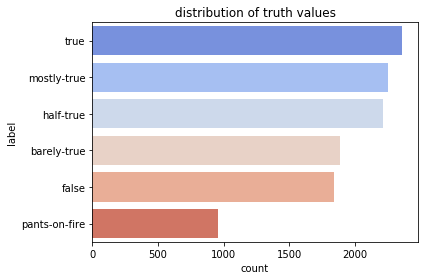

In [55]:
liar_truthdist_subj()

In [10]:
liar_train['speaker_affiliation'].value_counts()

republican                      5094
democrat                        3731
none                            1967
organization                     237
independent                      166
newsmaker                         63
libertarian                       46
activist                          43
journalist                        40
columnist                         37
talk-show-host                    29
state-official                    20
labor-leader                      15
business-leader                   10
tea-party-member                  10
green                              3
education-official                 3
constitution-party                 2
liberal-party-canada               1
government-body                    1
Moderate                           1
democratic-farmer-labor            1
county-commissioner                1
ocean-state-tea-party-action       1
Name: speaker_affiliation, dtype: int64

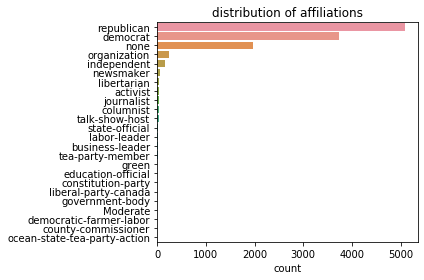

In [56]:
sns.barplot(y=liar_train['speaker_affiliation'].value_counts().index, x=liar_train['speaker_affiliation'].value_counts()).set(title='distribution of affiliations', xlabel='count')
plt.tight_layout()
plt.savefig('./image/liar_affiliations_dist.png');

In [12]:
liar_speakers_full = liar_train[liar_speaker_headers]

liar_speakers = liar_speakers_full.drop_duplicates().sort_values(by='speaker')
#liar_speakers['count_in_set'] = liar_speakers_full.groupby(liar_speaker_headers, as_index=False).size().values

liar_speakers['speaker'].value_counts()

#liar_speakers_full.groupby('speaker', as_index=False).size()

robert-puente                  2
kasim-reed                     2
danny-tarkanian                2
nh-afl-cio                     1
mark-schlereth                 1
                              ..
oregon-business-association    1
philadelphia-daily-news        1
new-approach-oregon            1
emilys-list                    1
critics-water-fluoridation     1
Name: speaker, Length: 3126, dtype: int64

Inconsistencies are due to the merging of the default train and validation sets

In [57]:
liar_train[liar_train['speaker']=='kasim-reed']

,label,statement,subjects,speaker,speaker_job,speaker_us_state,speaker_affiliation,speaker_bt,speaker_f,speaker_ht,speaker_mt,speaker_pof,context
id,,,,,,,,,,,,,
4659.json,true,On letting Occupy Atlanta protesters stay in W...,"occupy-wall-street,public-safety",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,statements to the public
7862.json,mostly-true,My office is about a 300-step walk to the gove...,"city-government,economy",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,leadership forum
9749.json,true,The minimum number of infrastructure (needs) i...,city-government,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,press conference
8186.json,true,State law says that once the state appraises a...,"city-government,corrections-and-updates,sports",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,an interview
8898.json,mostly-true,"Right now, we only keep 50 percent of Georgia ...","economy,education,jobs",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,a speech
8171.json,mostly-true,"Atlanta now has as many visitors as Las Vegas,...",tourism,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,a radio interview
8938.json,true,The annual gross domestic product of metro Atl...,economy,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,a speech
7228.json,false,On same-sex marriage,"civil-rights,gays-and-lesbians,marriage",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,NaN
6038.json,pants-fire,The new Hartsfield-Jackson international termi...,transportation,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,press conference


We don't need the counts for individual speaker truth values, especially when there's no date attached

TODO: pull from main API to extract date of news?

Need to convert subjects column into a list

In [58]:
liar_train['subject_list'] = liar_train['subjects'].apply(lambda s: str(s).split(','))
liar_test['subject_list'] = liar_test['subjects'].apply(lambda s: str(s).split(','))

liar_train_subj_dummies = eda.createdummy_from_listentries(liar_train, 'subject_list')

liar_train_subj_dummies

,Alcohol,abc-news-week,abortion,afghanistan,after-the-fact,agriculture,animals,autism,bankruptcy,baseball,...,unions,urban,veterans,voting-record,water,wealth,weather,welfare,women,workers
id,,,,,,,,,,,,,,,,,,,,,
2635.json,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10540.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1123.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9028.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12548.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
401.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
LIAR_SUBJ_THRESHOLD = 200

liar_train_subj_summary = pd.DataFrame(data=liar_train_subj_dummies.sum(), 
                                       columns=['count']).sort_values(by='count', 
                                                                      ascending=False)
liar_train_subj_summary['is_minor'] = liar_train_subj_summary['count'] < LIAR_SUBJ_THRESHOLD

liar_train_subj_summary

,count,is_minor
economy,1009,False
health-care,854,False
candidates-biography,663,False
education,625,False
elections,471,False
...,...,...
wealth,2,True
urban,1,True
death-penalty,1,True
homeless,1,True


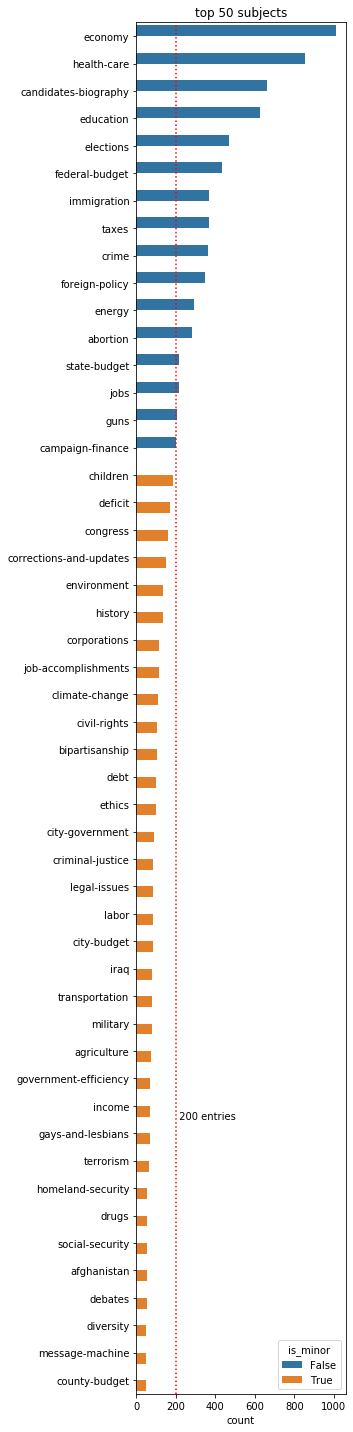

In [217]:
LIAR_SUBJ_COUNT_PLOTTED = 100

fig, ax = plt.subplots(figsize=(5,20))

sns.barplot(x=liar_train_subj_summary.head(LIAR_SUBJ_COUNT_PLOTTED)['count'], y=liar_train_subj_summary.head(LIAR_SUBJ_COUNT_PLOTTED).index, ax=ax, hue=liar_train_subj_summary.head(LIAR_SUBJ_COUNT_PLOTTED)['is_minor']).set(title='top ' + str(LIAR_SUBJ_COUNT_PLOTTED) + ' subjects')
plt.axvline(LIAR_SUBJ_THRESHOLD, color='red', linestyle=':')
plt.text(LIAR_SUBJ_THRESHOLD, 0.2, " " + str(LIAR_SUBJ_THRESHOLD) + " entries", transform=ax.get_xaxis_transform())
plt.tight_layout()
plt.savefig('./image/liar_subj_dist_top100.png');

(           label  count
 0           true     11
 1    mostly-true      7
 2      half-true      6
 3    barely-true      5
 4          false      5
 5  pants-on-fire      3,
 <matplotlib.axes._subplots.AxesSubplot at 0x21015974488>)

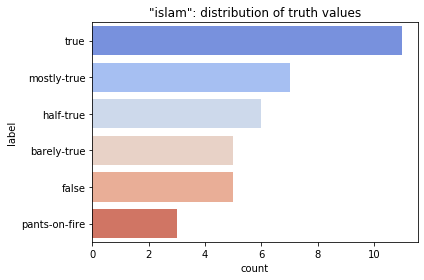

In [16]:
liar_truthdist_subj('islam')

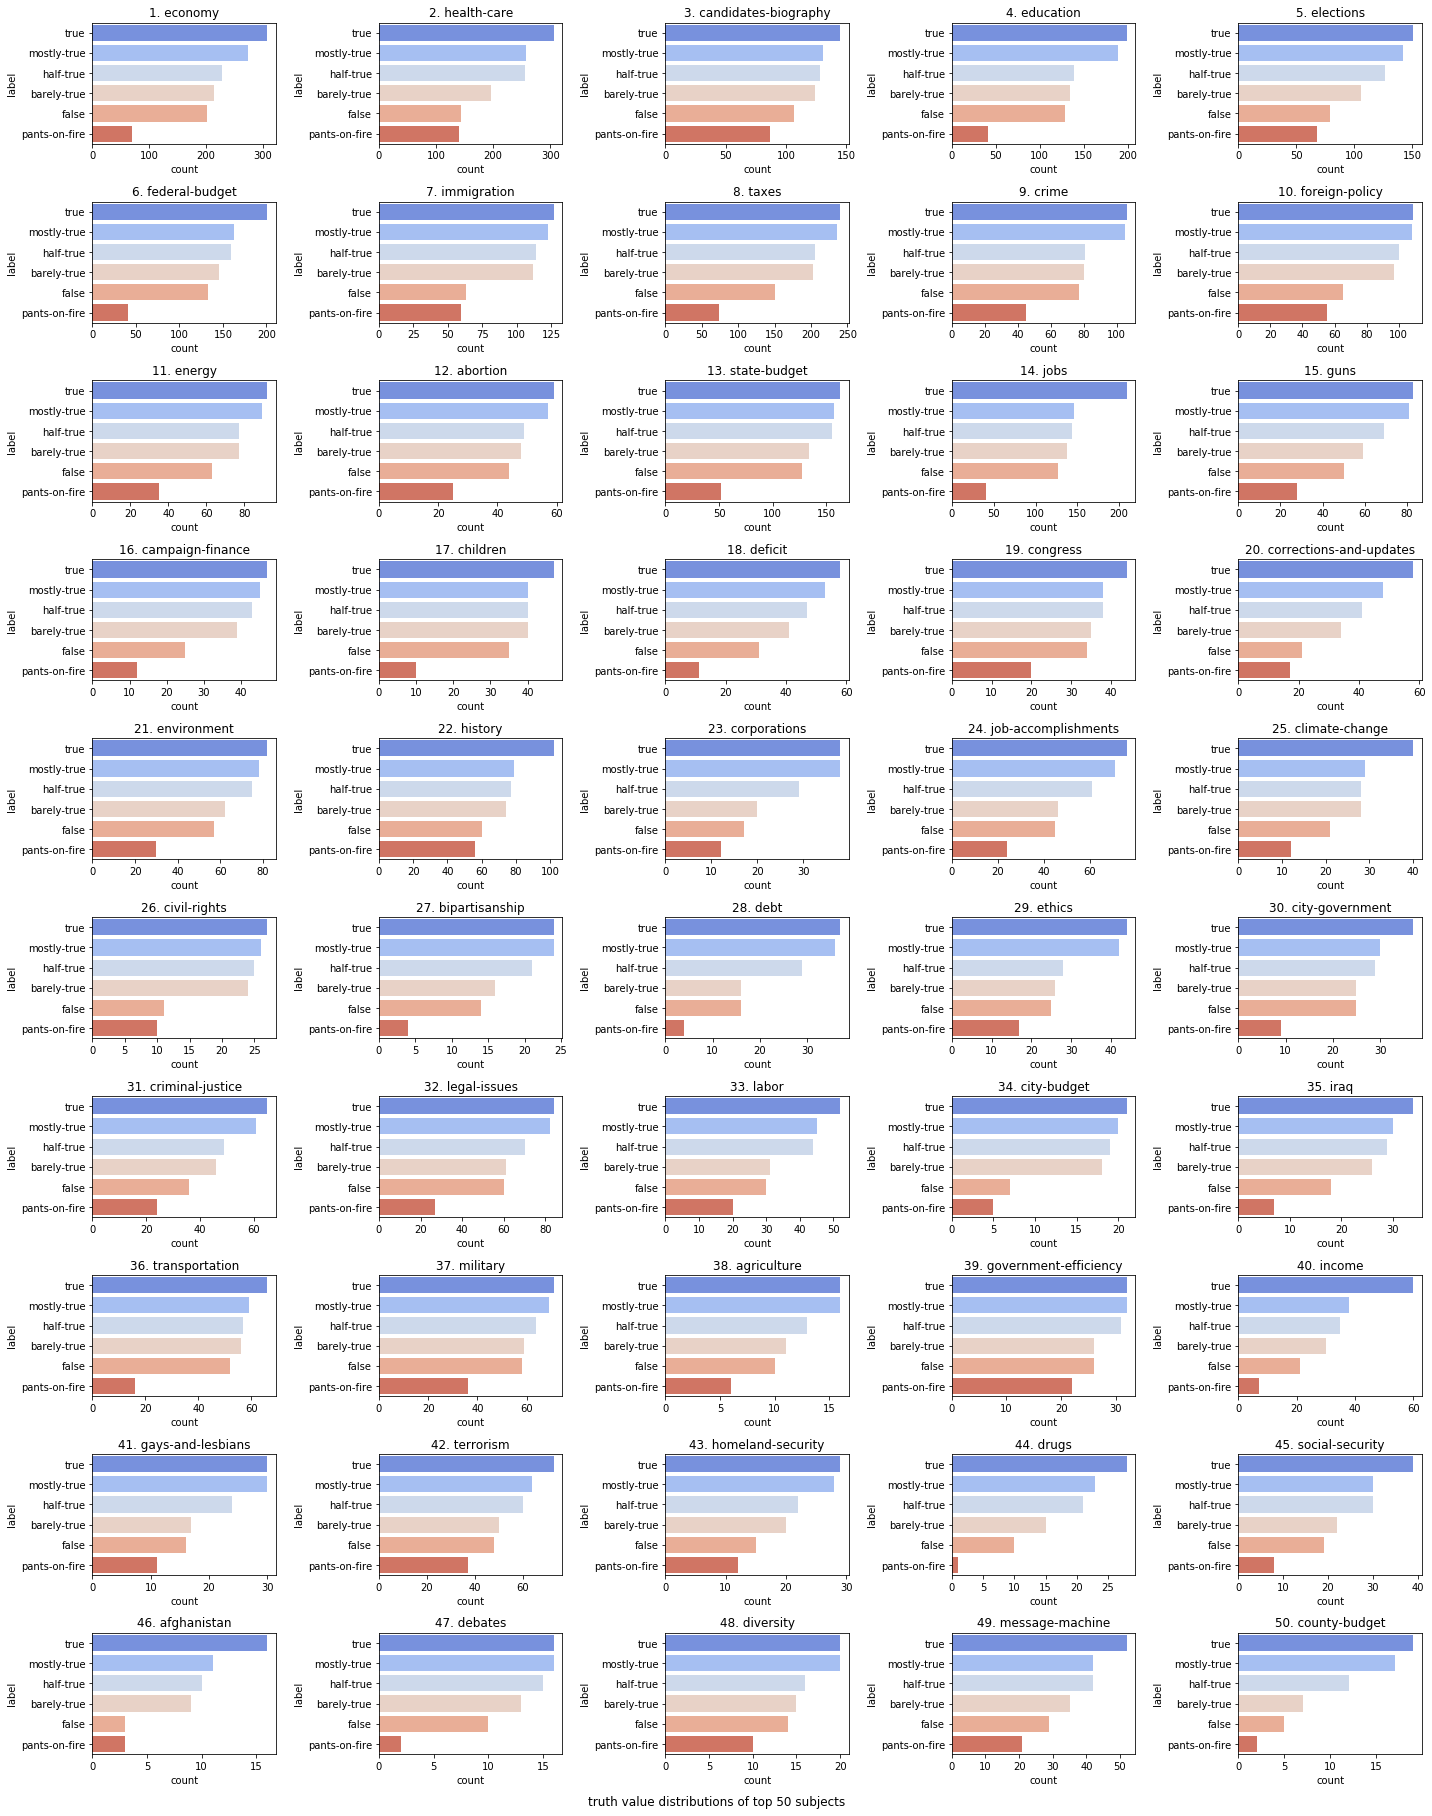

In [17]:
num_figs = 50
fig = plt.figure(figsize=(20,25))

for counter, subj in zip(range(0,num_figs), liar_train_subj_summary.index):
    ax = plt.subplot(10, 5, counter + 1)
    _ = liar_truthdist_subj(subj, ax=ax, saveplot=False)
    ax.set(title=str(counter + 1) + ". " + subj)

fig.suptitle('truth value distributions of top ' + str(num_figs) + ' subjects').set_y(0)

plt.tight_layout()
plt.savefig('./image/liar_top50_truthvals_dist.png')

In [168]:
# join truth value label to dummy col
liar_train_truthval = liar_train_subj_dummies.join(liar_train['label'])

# map summation of dummy vals based on index (which is subj)
for truth_value in liar_label_order:
    liar_train_subj_summary[truth_value] = liar_train_subj_summary.index.map(
        lambda x: liar_train_truthval[liar_train_truthval['label'] == truth_value][x].sum()
    )

liar_train_subj_summary

,count,is_minor,true,mostly-true,half-true,barely-true,false,pants-fire
economy,1009,False,184,208,249,161,157,50
health-care,854,False,99,127,163,160,206,99
candidates-biography,663,False,99,118,118,112,136,80
education,625,False,105,142,142,101,105,30
elections,471,False,94,90,68,60,100,59
...,...,...,...,...,...,...,...,...
wealth,2,True,1,0,1,0,0,0
urban,1,True,1,0,0,0,0,0
death-penalty,1,True,1,0,0,0,0,0
homeless,1,True,0,0,0,1,0,0


In [172]:
liar_train_subj_summary.loc['economy'][liar_label_order].sum()

1009

In [196]:
def stacked_plot(df, cats, stack_cat_label='category', cat_axis='y', stack_cat=None, stack_cat_palette='coolwarm'):
    
    cat_colors = sns.color_palette(palette=stack_cat_palette, n_colors=len(stack_cat))
      
    #define start points for each stack of bar plot
    start_pts = [np.array([0] * len(cats))]
    for cat in stack_cat:
        start_pts.append(start_pts[-1] + np.array(df[cat]))
    start_pts.pop()

    # draw last cat first, we're layering bar plots on top of each other
    for cat, cat_color, start_pt in zip(reversed(stack_cat), reversed(cat_colors), reversed(start_pts)):
        if cat_axis == 'y':
            sns.barplot(y=cats, x=df[cat] + start_pt, color=cat_color, label=cat)
        else:
            sns.barplot(x=cats, y=df[cat] + start_pt, color=cat_color, label=cat)
    
    if cat_axis == 'y':
        plt.xlabel(cat_label)
    else:
        plt.ylabel(cat_label)
    
    plt.legend();

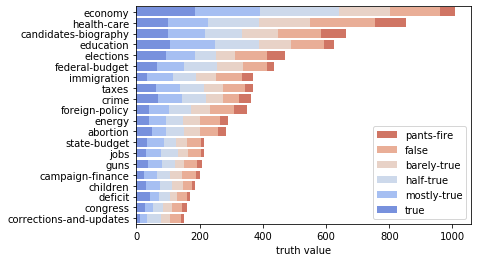

In [197]:
stacked_plot(liar_train_subj_summary.head(20), 
             liar_train_subj_summary.head(20).index, 
             stack_cat_label='truth value', 
             stack_cat=liar_label_order)

In [198]:
liar_train.columns

Index(['label', 'statement', 'subjects', 'speaker', 'speaker_job',
       'speaker_us_state', 'speaker_affiliation', 'speaker_bt', 'speaker_f',
       'speaker_ht', 'speaker_mt', 'speaker_pof', 'context', 'subject_list'],
      dtype='object')

# Classification w/o NLP

## Take 1: most features in

Using only select speaker features and subjects; ignoring the cumulative truth values as they could be from any time period

In [ ]:
# initialise the cat encoder
enc = OneHotEncoder(handle_unknown='ignore')

In [218]:
enc.fit(liar_train[['speaker']].fillna(''))
enc.transform(liar_train[['speaker']].fillna(''))

<11524x3127 sparse matrix of type '<class 'numpy.float64'>'
	with 11524 stored elements in Compressed Sparse Row format>

There are >3k unique 'speakers'

In [216]:
enc.fit(liar_train[['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation']].fillna(''))
enc.transform(liar_train[['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation']].fillna(''))

<11524x4509 sparse matrix of type '<class 'numpy.float64'>'
	with 46096 stored elements in Compressed Sparse Row format>

Adding the other speaker features adds about 1.4k features

In [223]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(liar_train[['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation']].fillna(''))
speaker_dummies = enc.transform(liar_train[['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation']].fillna(''))

train_X = pd.DataFrame(data=speaker_dummies, 
                       index=liar_train.index, 
                       columns=enc.get_feature_names()).join(liar_train_subj_dummies).fillna('')
train_y = liar_train['label']

train_X, train_y

(            x0_  x0_13th-district-gop-slate  x0_18-percent-american-public  \
 id                                                                           
 2635.json   0.0                         0.0                            0.0   
 10540.json  0.0                         0.0                            0.0   
 324.json    0.0                         0.0                            0.0   
 1123.json   0.0                         0.0                            0.0   
 9028.json   0.0                         0.0                            0.0   
 ...         ...                         ...                            ...   
 3419.json   0.0                         0.0                            0.0   
 12548.json  0.0                         0.0                            0.0   
 401.json    0.0                         0.0                            0.0   
 1055.json   0.0                         0.0                            0.0   
 9117.json   0.0                         0.0        

Use the default random forest to do feature importance selection

In [225]:
feature_sel_rforest = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

feature_sel_rforest.fit(train_X, train_y)

feature_rank_df = pd.DataFrame()
feature_rank_df['feature'] = train_X.columns
feature_rank_df['importance'] = feature_sel_rforest.feature_importances_

In [228]:
feature_rank_df.sort_values('importance', ascending=False).head(50)

,feature,importance
4549,economy,0.015742
4523,candidates-biography,0.014463
4571,health-care,0.013377
4557,federal-budget,0.012790
4550,education,0.012774
4633,taxes,0.012284
4551,elections,0.011151
4539,crime,0.010436
4578,immigration,0.009821
4511,abortion,0.009444


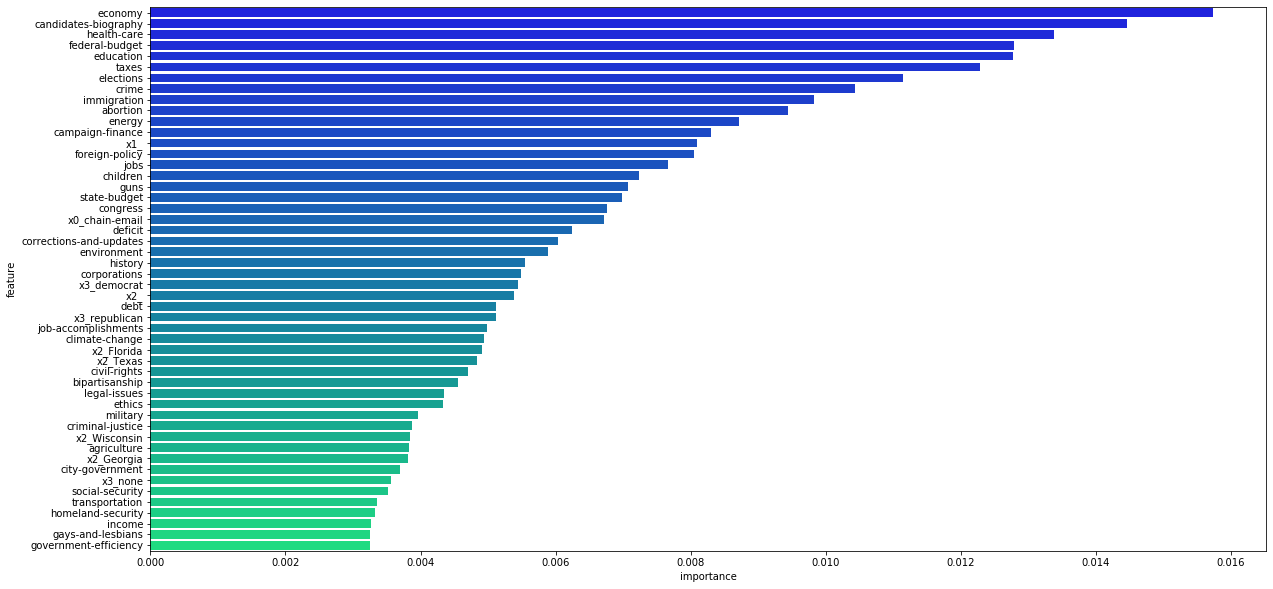

In [232]:
plt.figure(figsize=(20,10))
sns.barplot(data=feature_rank_df, x='importance', y='feature', order=feature_rank_df.sort_values('importance', ascending=False).head(50).feature, palette='winter')
plt.savefig("image/rforest_feature_importance.png");

It appears that the speaker features are not predictive at all!  What about random forest performance?

In [284]:
model_rforest = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

f1scorer = make_scorer(fbeta_score, beta=1, average='weighted')

#create a dictionary of all values we want to test for n_neighbors
param_grid = {  'n_estimators':         [5, 10, 20, 40, 100], 
                'max_depth':            [5, 7, 10], 
                'min_samples_split':    [2, 3, 4]}

#use gridsearch to test all values for n_neighbors
model_rforest_rscv = RandomizedSearchCV(model_rforest, 
                                        param_grid, 
                                        cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM), 
                                        scoring=f1scorer, 
                                        random_state=RANDOM, 
                                        n_iter=20)

#fit model to data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 100, 'min_samples_split': 3, 'max_depth': 10}

In [285]:
model_rforest_rscv.best_score_

0.5094727073676297

In [286]:
results_rforest_rscv = pd.DataFrame(model_rforest_rscv.cv_results_)

results_rforest_rscv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.400198,0.295654,0.131236,0.004361,100,3,10,"{'n_estimators': 100, 'min_samples_split': 3, ...",0.493961,0.512533,0.517482,0.529081,0.494307,0.509473,0.013628,1
1,0.031800,0.003543,0.130548,0.003002,5,4,7,"{'n_estimators': 5, 'min_samples_split': 4, 'm...",0.493961,0.512533,0.517482,0.529081,0.494307,0.509473,0.013628,1
2,0.043200,0.003188,0.130409,0.002876,10,4,7,"{'n_estimators': 10, 'min_samples_split': 4, '...",0.493961,0.512533,0.517482,0.529081,0.494307,0.509473,0.013628,1
3,0.111800,0.001940,0.126121,0.001870,40,4,10,"{'n_estimators': 40, 'min_samples_split': 4, '...",0.493961,0.512533,0.517482,0.529081,0.494307,0.509473,0.013628,1
4,0.034601,0.003071,0.133765,0.005180,5,3,10,"{'n_estimators': 5, 'min_samples_split': 3, 'm...",0.493961,0.512533,0.517482,0.529081,0.494307,0.509473,0.013628,1
5,0.045799,0.002482,0.130380,0.006180,10,4,10,"{'n_estimators': 10, 'min_samples_split': 4, '...",0.493961,0.512533,0.517482,0.529081,0.494307,0.509473,0.013628,1
6,0.217799,0.005741,0.127179,0.002835,100,2,5,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.493961,0.512533,0.517482,0.529081,0.494307,0.509473,0.013628,1
7,0.065599,0.004127,0.131429,0.006754,20,4,5,"{'n_estimators': 20, 'min_samples_split': 4, '...",0.493961,0.512533,0.517482,0.529081,0.494307,0.509473,0.013628,1
8,0.115999,0.002450,0.132038,0.003632,40,3,5,"{'n_estimators': 40, 'min_samples_split': 3, '...",0.493961,0.512533,0.517482,0.529081,0.494307,0.509473,0.013628,1
9,0.112997,0.004380,0.126344,0.005316,40,2,5,"{'n_estimators': 40, 'min_samples_split': 2, '...",0.493961,0.512533,0.517482,0.529081,0.494307,0.509473,0.013628,1


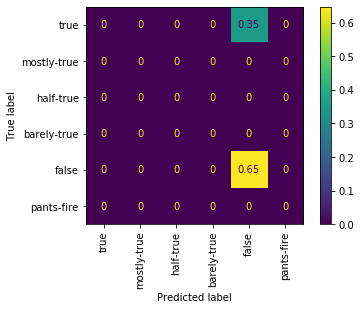

In [287]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      normalize='all',
                      xticks_rotation='vertical');

Don't let the f1 score mislead you; the confusion matrix shows that it's a terrible performance! Can we do better with just the subjects?

## Take 2: just the subjects

In [302]:
train_X = liar_train_subj_dummies
train_y = liar_train['label']

train_X, train_y

(            Alcohol  abc-news-week  abortion  afghanistan  after-the-fact  \
 id                                                                          
 2635.json         0              0         1            0               0   
 10540.json        0              0         0            0               0   
 324.json          0              0         0            0               0   
 1123.json         0              0         0            0               0   
 9028.json         0              0         0            0               0   
 ...             ...            ...       ...          ...             ...   
 3419.json         0              0         0            0               0   
 12548.json        0              0         0            0               0   
 401.json          0              0         0            0               0   
 1055.json         0              0         0            0               0   
 9117.json         0              0         0            0      

In [303]:
feature_sel_rforest.fit(train_X, train_y)

feature_rank_df = pd.DataFrame()
feature_rank_df['feature'] = train_X.columns
feature_rank_df['importance'] = feature_sel_rforest.feature_importances_

In [304]:
feature_rank_df.sort_values('importance', ascending=False).head(50)

,feature,importance
62,health-care,0.029621
40,economy,0.020631
110,religion,0.019416
42,elections,0.017671
97,patriotism,0.016195
27,corrections-and-updates,0.014859
78,labor,0.013684
94,obama-birth-certificate,0.013215
86,message-machine,0.012501
63,history,0.011987


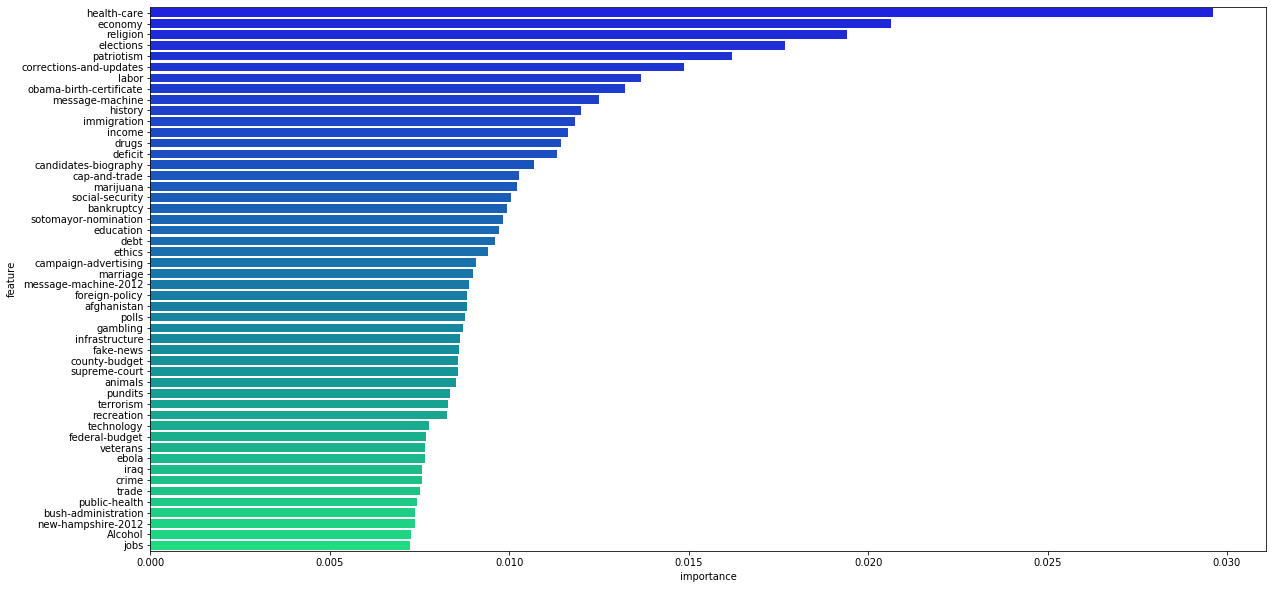

In [306]:
plt.figure(figsize=(20,10))
sns.barplot(data=feature_rank_df, x='importance', y='feature', order=feature_rank_df.sort_values('importance', ascending=False).head(50).feature, palette='winter')
plt.savefig("image/rforest_feature_importance_subjs_only.png");

In [310]:
liar_train_subj_summary.head(20).index

Index(['economy', 'health-care', 'candidates-biography', 'education',
       'elections', 'federal-budget', 'immigration', 'taxes', 'crime',
       'foreign-policy', 'energy', 'abortion', 'state-budget', 'jobs', 'guns',
       'campaign-finance', 'children', 'deficit', 'congress',
       'corrections-and-updates'],
      dtype='object')

In [314]:
list(feature_rank_df.sort_values('importance', ascending=False).head(20)['feature'])

['health-care',
 'economy',
 'religion',
 'elections',
 'patriotism',
 'corrections-and-updates',
 'labor',
 'obama-birth-certificate',
 'message-machine',
 'history',
 'immigration',
 'income',
 'drugs',
 'deficit',
 'candidates-biography',
 'cap-and-trade',
 'marijuana',
 'social-security',
 'bankruptcy',
 'sotomayor-nomination']

Top 20 subjects by count not the same as top 20 subjects by random forest feature importance

In [289]:
#fit model to new data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 40, 'min_samples_split': 4, 'max_depth': 10}

In [290]:
model_rforest_rscv.best_score_

0.13610345865022105

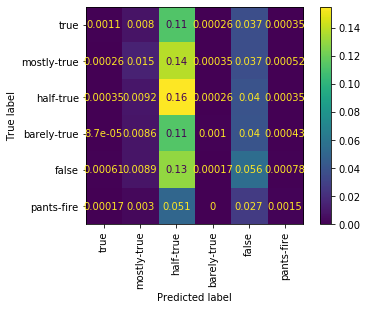

In [291]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      normalize='all',
                      xticks_rotation='vertical');

Appears to be mostly predicting 'half-true', champion sitting-on-the-fence behaviour; 'false' is the second most prelevant prediction. What if we limit ourselves to top 20 subjects with the rest as others, and maybe put speaker affiliation back in?

## Take 3: limiting subjects, including speaker affiliations

Try top 20 most common subjects first

In [320]:
top20_subjs_bycount = list(liar_train_subj_summary.head(20).index)

In [293]:
train_X = liar_train_subj_dummies[top20_subjs_bycount]
train_y = liar_train['label']

train_X, train_y

(            economy  health-care  candidates-biography  education  elections  \
 id                                                                             
 2635.json         0            0                     0          0          0   
 10540.json        0            0                     0          0          0   
 324.json          0            0                     0          0          0   
 1123.json         0            1                     0          0          0   
 9028.json         1            0                     0          0          0   
 ...             ...          ...                   ...        ...        ...   
 3419.json         0            0                     0          0          0   
 12548.json        0            0                     1          0          0   
 401.json          0            1                     0          0          0   
 1055.json         0            1                     0          0          0   
 9117.json         0        

In [294]:
#fit model to new data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 20, 'min_samples_split': 2, 'max_depth': 10}

In [295]:
model_rforest_rscv.best_score_

0.14153313167778248

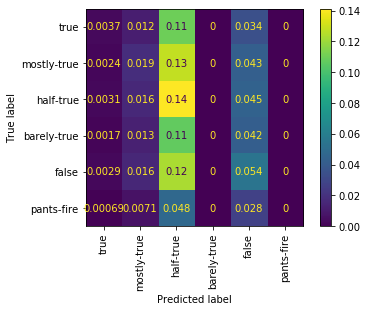

In [296]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      normalize='all',
                      xticks_rotation='vertical');

Slight improvement in score when subjects capped but behaviour fundamentally unchanged (just more predictions in 'false'). Let's now try top 20 subjects by feature importance.

In [321]:
top20_subjs_byimportance = list(feature_rank_df.sort_values('importance', ascending=False).head(20)['feature'])

In [316]:
train_X = liar_train_subj_dummies[top20_subjs_byimportance]
train_y = liar_train['label']

train_X, train_y

(            health-care  economy  religion  elections  patriotism  \
 id                                                                  
 2635.json             0        0         0          0           0   
 10540.json            0        0         0          0           0   
 324.json              0        0         0          0           0   
 1123.json             1        0         0          0           0   
 9028.json             0        1         0          0           0   
 ...                 ...      ...       ...        ...         ...   
 3419.json             0        0         0          0           0   
 12548.json            0        0         0          0           0   
 401.json              1        0         0          0           0   
 1055.json             1        0         0          0           0   
 9117.json             0        0         0          0           0   
 
             corrections-and-updates  labor  obama-birth-certificate  \
 id             

In [317]:
#fit model to new data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 20, 'min_samples_split': 2, 'max_depth': 10}

In [318]:
model_rforest_rscv.best_score_

0.13124424163840567

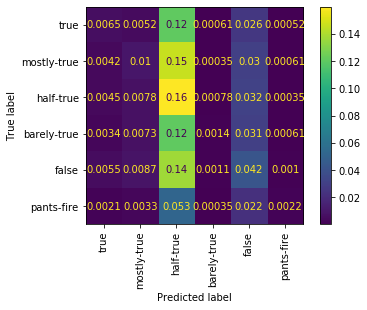

In [319]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      normalize='all',
                      xticks_rotation='vertical');

Doesn't seem to do as well, let's stick with top 20 by count for this next part

In [325]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(liar_train[['speaker_affiliation']].fillna(''))
speaker_dummies = enc.transform(liar_train[['speaker_affiliation']].fillna(''))

train_X = pd.DataFrame(data=speaker_dummies, 
                       index=liar_train.index, 
                       columns=enc.get_feature_names()).join(liar_train_subj_dummies[top20_subjs_bycount]).fillna('')
train_y = liar_train['label']

train_X, train_y

(            x0_  x0_Moderate  x0_activist  x0_business-leader  x0_columnist  \
 id                                                                            
 2635.json   0.0          0.0          0.0                 0.0           0.0   
 10540.json  0.0          0.0          0.0                 0.0           0.0   
 324.json    0.0          0.0          0.0                 0.0           0.0   
 1123.json   0.0          0.0          0.0                 0.0           0.0   
 9028.json   0.0          0.0          0.0                 0.0           0.0   
 ...         ...          ...          ...                 ...           ...   
 3419.json   0.0          0.0          0.0                 0.0           0.0   
 12548.json  0.0          0.0          0.0                 0.0           0.0   
 401.json    0.0          0.0          0.0                 0.0           0.0   
 1055.json   0.0          0.0          0.0                 0.0           0.0   
 9117.json   0.0          0.0          0

In [326]:
#fit model to new data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 20, 'min_samples_split': 4, 'max_depth': 10}

In [327]:
model_rforest_rscv.best_score_

0.1716519667692084

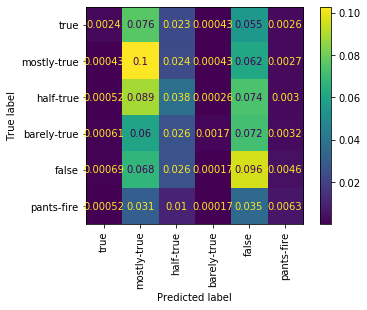

In [328]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      normalize='all',
                      xticks_rotation='vertical');

Better, but not by much. The predictions have shifted from 'half-true' to 'mostly-true'. Let's try a binary match.

## Take 4: Make target binary

In [329]:
train_y = liar_train['label'].replace('mostly-true', 'true').replace(['half-true', 'barely-true', 'pants-fire'], 'false')

train_y

id
2635.json     false
10540.json    false
324.json       true
1123.json     false
9028.json     false
              ...  
3419.json     false
12548.json     true
401.json       true
1055.json     false
9117.json     false
Name: label, Length: 11524, dtype: object

In [330]:
#fit model to new data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 5, 'min_samples_split': 3, 'max_depth': 10}

In [331]:
model_rforest_rscv.best_score_

0.5280181033959195

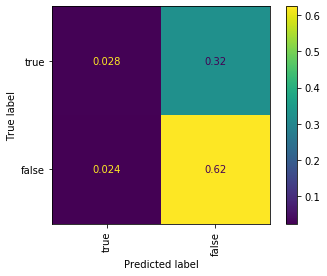

In [332]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=['true','false'], 
                      normalize='all',
                      xticks_rotation='vertical');

Again, pretty terrible performance. Let's see if NLP can come to the rescue.

# NLP exploration

We can work on two features: 'statement' and 'context'. Let's start with 'statement'.

In [337]:
#clean the statement data

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

liar_train['statement_clean'] = liar_train.statement.map(alphanumeric).map(punc_lower)
liar_test['statement_clean'] = liar_test.statement.map(alphanumeric).map(punc_lower)

#vectorise the words
cv1 = CountVectorizer(stop_words='english')

statement_train_cv1 = cv1.fit_transform(liar_train['statement_clean'])
statement_test_cv1  = cv1.transform(liar_test['statement_clean'])

pd.DataFrame(statement_train_cv1.toarray(), columns=cv1.get_feature_names(), index=liar_train.index)

,aa,aaa,aaron,aarp,aba,abandoned,abandoning,abbas,abbott,abc,...,zippo,zombie,zombies,zone,zones,zoning,zoo,zuckerberg,zuckerbergs,ʺmore
id,,,,,,,,,,,,,,,,,,,,,
2635.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10540.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1123.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9028.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12548.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
401.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


That's a hella lotta features!

Can single words of statement alone help predict?

In [338]:
train_X = pd.DataFrame(statement_train_cv1.toarray(), columns=cv1.get_feature_names(), index=liar_train.index)
train_y = liar_train['label']

In [339]:
#fit model to new data
model_rforest_rscv.fit(train_X, train_y)
model_rforest_rscv.best_params_

{'n_estimators': 20, 'min_samples_split': 2, 'max_depth': 10}

In [340]:
model_rforest_rscv.best_score_

0.12932932235860184

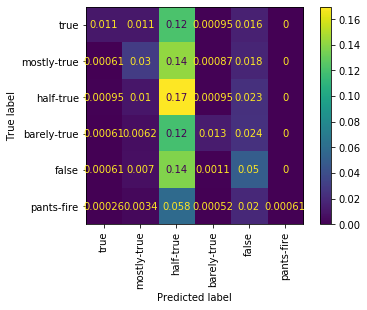

In [342]:
plot_confusion_matrix(model_rforest_rscv, train_X, train_y, 
                      labels=liar_label_order, 
                      normalize='all',
                      xticks_rotation='vertical');

That's pretty bad. Let's try Stanford's Stanza

In [416]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [344]:
import stanza
stanza.download('en')       # This downloads the English models for the neural pipeline

2020-06-04 23:08:35 INFO: Downloading default packages for language: en (English)...
2020-06-04 23:10:48 INFO: Finished downloading models and saved to C:\Users\vi_ci\stanza_resources.
2020-06-04 23:10:48 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| ner       | ontonotes |

2020-06-04 23:10:48 INFO: Use device: cpu
2020-06-04 23:10:48 INFO: Loading: tokenize
2020-06-04 23:10:48 INFO: Loading: pos
2020-06-04 23:10:49 INFO: Loading: lemma
2020-06-04 23:10:49 INFO: Loading: depparse
2020-06-04 23:10:50 INFO: Loading: ner
2020-06-04 23:10:50 INFO: Done loading processors!


('Barack', '4', 'nsubj:pass')
('Obama', '1', 'flat')
('was', '4', 'aux:pass')
('born', '0', 'root')
('in', '6', 'case')
('Hawaii', '4', 'obl')
('.', '4', 'punct')


In [417]:
nlp = stanza.Pipeline('en', use_gpu=True, pos_batch_size=3000)
doc = nlp("Barack Obama was born in Hawaii.  He was elected president in 2008.")
doc.sentences[0].print_dependencies()

2020-06-05 09:52:35 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| ner       | ontonotes |

2020-06-05 09:52:35 INFO: Use device: cpu
2020-06-05 09:52:35 INFO: Loading: tokenize
2020-06-05 09:52:35 INFO: Loading: pos
2020-06-05 09:52:36 INFO: Loading: lemma
2020-06-05 09:52:36 INFO: Loading: depparse
2020-06-05 09:52:37 INFO: Loading: ner
2020-06-05 09:52:37 INFO: Done loading processors!


('Barack', '4', 'nsubj:pass')
('Obama', '1', 'flat')
('was', '4', 'aux:pass')
('born', '0', 'root')
('in', '6', 'case')
('Hawaii', '4', 'obl')
('.', '4', 'punct')


In [356]:
if os.path.isfile('data/statement.stanza'):
    statement_stanza = load('data/statement.stanza')
    dump(statement_stanza, 'data/statement.stanza')
else:
    statement_stanza = liar_train['statement'].apply(nlp)

In [ ]:
if os.path.isfile('data/statement_comb.stanza'):
    statement_comb_stanza = load('data/statement_comb.stanza')
    dump(statement_comb_stanza, 'data/statement_comb.stanza')
else:
    statement_comb_stanza = nlp('\n\n'.join(liar_train['statement']))

In [418]:
stnlp.extract_pos(statement_stanza[0])

,word,pos,exp
0,Says,VERB,NA
1,the,DET,NA
2,Annies,PROPN,NA
3,List,NOUN,NA
4,political,ADJ,NA
5,group,NOUN,NA
6,supports,VERB,NA
7,third,ADJ,NA
8,-,PUNCT,NA
9,trimester,NOUN,NA


In [ ]:
dump(statement_stanza, 'data/statement_comb.stanza')